# 🔍 Détection de Fake News Multimodale (Texte + Image)

Ce notebook implémente un système complet de détection de fake news utilisant à la fois le contenu textuel et les images des articles.

## Structure du projet :
1. **Chargement des données** - Fusion automatique des fichiers CSV
2. **Prétraitement** - Nettoyage et téléchargement des images
3. **Analyse exploratoire** - Statistiques et visualisations
4. **Préparation des données** - Encodage BERT + CNN features
5. **Modélisation multimodale** - Fusion des embeddings
6. **Évaluation** - Métriques de performance
7. **Test en temps réel** - Interface de prédiction

## 📦 Installation des dépendances

In [ ]:
# Installation des packages nécessaires
!pip install torch torchvision transformers pandas numpy matplotlib seaborn
!pip install scikit-learn requests pillow tqdm hashlib2
!pip install datasets accelerate

You should consider upgrading via the 'c:\work( sous disque c)\4eme esprit\stage d'été\fakenews project\env\scripts\python.exe -m pip install --upgrade pip' command.


ERROR: Could not find a version that satisfies the requirement hashlib2 (from versions: none)
ERROR: No matching distribution found for hashlib2
You should consider upgrading via the 'c:\work( sous disque c)\4eme esprit\stage d'été\fakenews project\env\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\work( sous disque c)\4eme esprit\stage d'été\fakenews project\env\scripts\python.exe -m pip install --upgrade pip' command.


## 📚 Imports et configuration

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import hashlib
import requests
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Transformers pour BERT
from transformers import AutoTokenizer, AutoModel

# Sklearn pour les métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


# 1️⃣ Chargement des données

Chargement automatique de tous les fichiers CSV du dossier FakeNewsNetData avec détection automatique des labels.

In [ ]:
def load_fakenewsnet_data(data_folder='FakeNewsNetData'):
    """
    Charge tous les fichiers CSV du dossier FakeNewsNet et leur assigne un label :
    - 'fake' dans le nom → label = 0
    - 'real' dans le nom → label = 1
    """
    all_dataframes = []
    csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

    print(f"📁 {len(csv_files)} fichiers CSV trouvés dans {data_folder}/")

    for file_path in csv_files:
        filename = os.path.basename(file_path)
        try:
            df = pd.read_csv(file_path)

            if 'fake' in filename.lower():
                df['label'] = 0
                label_name = 'FAKE'
            elif 'real' in filename.lower():
                df['label'] = 1
                label_name = 'REAL'
            else:
                print(f"⚠️ Fichier ignoré (label non détecté) : {filename}")
                continue

            df = df.rename(columns={
                'title': 'title',
                'text': 'text',
                'image_url': 'image_url'
            })

            df['source'] = filename
            print(f"   ✅ {filename} chargé avec {len(df)} lignes - Label : {label_name}")
            all_dataframes.append(df)

        except Exception as e:
            print(f"   ❌ Erreur lors du chargement de {filename} : {e}")

    if not all_dataframes:
        print("❌ Aucun fichier FakeNewsNet valide chargé.")
        return pd.DataFrame()

    df_fakenewsnet = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n🎯 TOTAL FakeNewsNet : {len(df_fakenewsnet)} articles")
    print(df_fakenewsnet['label'].value_counts())

    return df_fakenewsnet


In [ ]:

def load_ifnd_data(ifnd_filepath):
    """
    Charge le fichier IFND.csv et adapte les colonnes.
    """
    try:
        df = pd.read_csv(ifnd_filepath, encoding='latin1')
        print(f"✅ IFND.csv chargé avec {len(df)} lignes")

        df = df.rename(columns={
            'Statement': 'title',
            'Web': 'text',
            'Image': 'image_url',
            'Label': 'label'
        })

        df = df[['title', 'text', 'image_url', 'label']]
        df['label'] = df['label'].map({'TRUE': 1, 'Fake': 0, 'FALSE': 0, 'REAL': 1})

        print(f"📋 Colonnes IFND : {list(df.columns)}")
        print(f"📊 Répartition des labels IFND :\n{df['label'].value_counts()}")

        return df

    except FileNotFoundError:
        print(f"❌ Fichier introuvable : {ifnd_filepath}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Erreur chargement IFND : {e}")
        return pd.DataFrame()


In [ ]:
# === Chargement des deux sources ===
folder_fakenewsnet = 'FakeNewsNetData'
path_ifnd = r"C:\work( sous disque C)\4eme Esprit\Stage d'été\FakeNews Project\FakeNewsNetData\IFND.csv"

df_fakenewsnet = load_fakenewsnet_data(folder_fakenewsnet)
df_ifnd = load_ifnd_data(path_ifnd)

# === Fusion des deux sources ===
df_combined = pd.concat([df_fakenewsnet, df_ifnd], ignore_index=True)

print(f"\n🔗 Fusion terminée : {len(df_combined)} articles au total")
print(f"🧾 Répartition globale des labels :\n{df_combined['label'].value_counts()}")
print(f"📋 Colonnes finales : {list(df_combined.columns)}")


📁 9 fichiers CSV trouvés dans FakeNewsNetData/
   ✅ BuzzFeed_fake_news_content.csv chargé avec 91 lignes - Label : FAKE
   ✅ BuzzFeed_real_news_content.csv chargé avec 91 lignes - Label : REAL
   ✅ gossipcop_fake.csv chargé avec 5323 lignes - Label : FAKE
   ✅ gossipcop_real.csv chargé avec 16817 lignes - Label : REAL
   ❌ Erreur lors du chargement de IFND.csv : 'utf-8' codec can't decode byte 0xd4 in position 10049: invalid continuation byte
   ✅ politifact_fake.csv chargé avec 432 lignes - Label : FAKE
   ✅ PolitiFact_fake_news_content.csv chargé avec 120 lignes - Label : FAKE
   ✅ politifact_real.csv chargé avec 624 lignes - Label : REAL
   ✅ PolitiFact_real_news_content.csv chargé avec 120 lignes - Label : REAL

🎯 TOTAL FakeNewsNet : 23618 articles
label
1    17652
0     5966
Name: count, dtype: int64
✅ IFND.csv chargé avec 56714 lignes
📋 Colonnes IFND : ['title', 'text', 'image_url', 'label']
📊 Répartition des labels IFND :
label
1    37800
0    18914
Name: count, dtype: int64

🔗 

# 2️⃣ Prétraitement des données

Nettoyage des données, gestion des URLs d'images et téléchargement.

In [ ]:
def preprocess_dataset_complet(df, source_name="dataset"):
    print(f"🧹 Début du prétraitement {source_name}...")
    initial_count = len(df)

    # Recréer image_url si besoin
    if 'image_url' not in df.columns or df['image_url'].isnull().all():
        df['image_url'] = None
        if 'top_img' in df.columns:
            df['image_url'] = df['top_img']
        elif 'images' in df.columns:
            def extract_first_image(images_str):
                if pd.isna(images_str) or images_str == '':
                    return None
                images = str(images_str).split()
                return images[0] if images else None
            df['image_url'] = df['images'].apply(extract_first_image)

    # Colonnes standard
    required_columns = ['title', 'text', 'image_url', 'label']
    for col in required_columns:
        if col not in df.columns:
            df[col] = "" if col == 'text' else None

    df = df[required_columns]

    # Nettoyage
    def clean_text(text):
        if pd.isna(text):
            return ""
        text = str(text).strip()
        return ''.join(char for char in text if ord(char) >= 32 or char in '\n\t')

    df['title'] = df['title'].apply(clean_text)
    df['text'] = df['text'].apply(clean_text)

    # Titre >= 10 obligatoire
    df = df[df['title'].str.len() >= 10]
    print(f"   ✅ Après filtre sur les titres : {len(df)} articles")

    # Text < 50 → vider
    df.loc[df['text'].str.len() < 50, 'text'] = ""

    # Image
    df['image_url'] = df['image_url'].astype(str)
    df['image_url'] = df['image_url'].replace(['nan', 'None', '', 'null'], None)

    def is_valid_image_url(url):
        if pd.isna(url) or url is None:
            return False
        url = str(url).strip()
        return url.startswith(('http://', 'https://')) and len(url) > 10

    df['has_image'] = df['image_url'].apply(is_valid_image_url)
    df.loc[~df['has_image'], 'image_url'] = None

    df['has_text'] = df['text'].apply(lambda x: isinstance(x, str) and len(x.strip()) >= 50)

    print(f"   🖼️ Images valides : {df['has_image'].sum()} / {len(df)}")
    print(f"   📄 Articles avec texte ≥ 50 chars : {df['has_text'].sum()} / {len(df)}")

    print(f"\n✅ Prétraitement {source_name} terminé : {initial_count} → {len(df)} articles conservés")
    print(f"📊 Répartition des labels :\n{df['label'].value_counts()}")

    return df


In [ ]:
df_all_clean = preprocess_dataset_complet(df_fakenewsnet, source_name="FakeNewsNet")
df_ifnd_clean = preprocess_dataset_complet(df_ifnd, source_name="IFND")


df_final = pd.concat([df_all_clean, df_ifnd_clean], ignore_index=True)

print(f"\n📦 Dataset final combiné : {len(df_final)} articles")
print(df_final[['title', 'has_text', 'has_image', 'label']].head())


🧹 Début du prétraitement FakeNewsNet...
   ✅ Après filtre sur les titres : 23618 articles
   🖼️ Images valides : 408 / 23618
   📄 Articles avec texte ≥ 50 chars : 420 / 23618

✅ Prétraitement FakeNewsNet terminé : 23618 → 23618 articles conservés
📊 Répartition des labels :
label
1    17652
0     5966
Name: count, dtype: int64
🧹 Début du prétraitement IFND...
   ✅ Après filtre sur les titres : 56714 articles
   🖼️ Images valides : 56714 / 56714
   📄 Articles avec texte ≥ 50 chars : 0 / 56714

✅ Prétraitement IFND terminé : 56714 → 56714 articles conservés
📊 Répartition des labels :
label
1    37800
0    18914
Name: count, dtype: int64

📦 Dataset final combiné : 80332 articles
                                               title  has_text  has_image  \
0  Proof The Mainstream Media Is Manipulating The...      True       True   
1  Charity: Clinton Foundation Distributed “Water...      True       True   
2  A Hillary Clinton Administration May be Entire...      True       True   
3  Trump

## 📥 Téléchargement des images

In [ ]:
'''
def download_images(df, images_folder='image_final_ancien', max_images=None):
    """
    1/Télécharge toutes les images valides à partir des URLs dans df['image_url'].
    Met à jour df avec le chemin local dans df['image_path'].

    Params:
        df (pd.DataFrame): DataFrame contenant au moins 'image_url' et 'label'.
        images_folder (str): dossier où sauvegarder les images.
        max_images (int or None): limite du nombre d'images à télécharger.

    Returns:
        pd.DataFrame: DataFrame filtré pour ne garder que les articles avec images téléchargées.
    """
    print(f"📥 Début du téléchargement des images dans '{images_folder}/'")

    os.makedirs(images_folder, exist_ok=True)

    # 2/Filtrer les articles avec URLs valides
    if 'has_valid_image_url' in df.columns:
        df_with_images = df[df['has_valid_image_url']].copy()
    else:
        # Si pas de colonne, on tente de valider ici même
        def is_valid_url(url):
            if pd.isna(url) or url is None:
                return False
            url = str(url).strip()
            return url.startswith(('http://', 'https://')) and len(url) > 10
        df['has_valid_image_url'] = df['image_url'].apply(is_valid_url)
        df_with_images = df[df['has_valid_image_url']].copy()

    if max_images:
        df_with_images = df_with_images.head(max_images)

    print(f"🎯 {len(df_with_images)} images à télécharger")

    successful_downloads = []
    failed_downloads = []

    for idx, row in df_with_images.iterrows():
        image_url = row['image_url']
        print(f"Téléchargement idx={idx} url={image_url[:60]}...")

        try:
            url_hash = hashlib.md5(image_url.encode('utf-8')).hexdigest()

            # Détection extension (jpg/png/gif/bmp/webp)
            ext = '.jpg'  # par défaut
            for candidate_ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']:
                if image_url.lower().endswith(candidate_ext):
                    ext = candidate_ext
                    break

            filename = f"{url_hash}{ext}"
            filepath = os.path.join(images_folder, filename)

            if os.path.exists(filepath):
                print(f"Image déjà téléchargée : {filename}")
                successful_downloads.append((idx, filepath))
                continue

            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }

            response = requests.get(image_url, headers=headers, timeout=15, stream=True)
            response.raise_for_status()

            content_type = response.headers.get('content-type', '')
            if not content_type.startswith('image/'):
                print(f"❌ Contenu non-image pour idx={idx}, type={content_type}")
                failed_downloads.append((idx, f"Type non-image: {content_type}"))
                continue

            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            # Vérification de l'image
            try:
                with Image.open(filepath) as img:
                    img.verify()
                print(f"✅ Image téléchargée et validée : {filename}")
                successful_downloads.append((idx, filepath))
            except Exception:
                os.remove(filepath)
                print(f"❌ Image corrompue supprimée : {filename}")
                failed_downloads.append((idx, "Image corrompue"))

        except Exception as e:
            print(f"❌ Erreur téléchargement idx={idx}: {e}")
            failed_downloads.append((idx, str(e)))

    print(f"\n✅ Téléchargements réussis: {len(successful_downloads)}")
    print(f"❌ Téléchargements échoués: {len(failed_downloads)}")

    # 3/Mise à jour DataFrame
    if 'image_path' not in df.columns:
        df['image_path'] = None

    for idx, filepath in successful_downloads:
        df.at[idx, 'image_path'] = filepath

    df_final = df[df['image_path'].notna()].copy()

    print(f"\n🎯 Dataset final avec images locales : {len(df_final)} articles")
    print(f"📊 Répartition des labels :")
    print(df_final['label'].value_counts())

    return df_final
    '''



In [ ]:
# Par exemple, après avoir préparé ton df_final (80332 articles) :

### df_with_images = download_images(df_final, images_folder='image_final_ancien', max_images=None)


📥 Début du téléchargement des images dans 'image_final_ancien/'
🎯 57122 images à télécharger
Téléchargement idx=0 url=http://addictinginfo.addictinginfoent.netdna-cdn.com/wp-cont...
❌ Erreur téléchargement idx=0: HTTPConnectionPool(host='addictinginfo.addictinginfoent.netdna-cdn.com', port=80): Max retries exceeded with url: /wp-content/uploads/2016/09/GettyImages-605695152.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000027A42FCC100>: Failed to resolve 'addictinginfo.addictinginfoent.netdna-cdn.com' ([Errno 11001] getaddrinfo failed)"))
Téléchargement idx=1 url=http://eaglerising.com/wp-content/uploads/2016/09/aids.jpg...
❌ Erreur téléchargement idx=1: HTTPSConnectionPool(host='128.199.163.117', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1131)')))
Téléchargement idx=2 url=http://eaglerising.com/wp-content/u

In [ ]:
'''
# === CONFIGURATION ===
images_folder = 'image_final_ancien'
downloaded_files = set(os.listdir(images_folder))

# === 1. Filtrer les articles de df_ifnd avec label = 0 et image valide non encore téléchargée ===
def image_not_downloaded(url):
    if pd.isna(url): return False
    url_hash = hashlib.md5(url.encode()).hexdigest()
    for ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']:
        if f"{url_hash}{ext}" in downloaded_files:
            return False
    return True

df_ifnd_real_images = df_ifnd[
    (df_ifnd['label'] == 0) &
    (df_ifnd['image_url'].notna()) &
    (df_ifnd['image_url'].apply(lambda url: url.startswith('http'))) &
    (df_ifnd['image_url'].apply(image_not_downloaded))
].copy()

print(f"🎯 Nombre d’articles (label = 0) avec image NON encore téléchargée : {len(df_ifnd_real_images)}")

# === 2. Télécharger les images manquantes ===
df_ifnd_real_images_downloaded = download_images(
    df_ifnd_real_images,
    images_folder=images_folder,
    max_images=3000  # ajuste si nécessaire
)
'''

🎯 Nombre d’articles (label = 0) avec image NON encore téléchargée : 13789
📥 Début du téléchargement des images dans 'image_final_ancien/'
🎯 3000 images à télécharger
Téléchargement idx=37800 url=https://akm-img-a-in.tosshub.com/indiatoday/images/story/202...
✅ Image téléchargée et validée : 22509a5660031a7e08f965aad6f5884f.jpg
Téléchargement idx=37801 url=https://akm-img-a-in.tosshub.com/indiatoday/images/story/202...
✅ Image téléchargée et validée : 6af7c3df3a84c147eb698800d09adcfc.jpg
Téléchargement idx=37802 url=https://akm-img-a-in.tosshub.com/indiatoday/images/story/202...
✅ Image téléchargée et validée : e31511d7fa0fa72543e414fd996a22ed.jpg
Téléchargement idx=37803 url=https://akm-img-a-in.tosshub.com/indiatoday/images/story/202...
✅ Image téléchargée et validée : 685d521f4ff29d0a47a71b7c5e98b759.jpg
Téléchargement idx=37804 url=https://akm-img-a-in.tosshub.com/indiatoday/images/story/202...
✅ Image téléchargée et validée : 6136460d28ee87087912358c7638f553.jpg
Téléchargement idx=

KeyboardInterrupt: 

## 🔄 Équilibrage des données

In [ ]:
df_all_clean['dataset_source'] = 'FakeNewsNet'
df_ifnd_clean['dataset_source'] = 'IFND'

df_final = pd.concat([df_all_clean, df_ifnd_clean], ignore_index=True)


In [ ]:

# === CONFIGURATION ===
images_folder = 'image_final_ancien'
downloaded_files = set(os.listdir(images_folder))

# === 1. Mettre à jour les colonnes image_path, has_image, has_text ===
def get_image_path(image_url):
    if pd.isna(image_url):
        return None
    url_hash = hashlib.md5(image_url.encode()).hexdigest()
    for ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']:
        filename = f"{url_hash}{ext}"
        if filename in downloaded_files:
            return os.path.join(images_folder, filename)
    return None

df_final['image_path'] = df_final['image_url'].apply(get_image_path)
df_final['has_image'] = df_final['image_path'].notna().astype(int)
df_final['has_text'] = df_final['text'].apply(lambda x: int(len(str(x).strip()) >= 50))

# === 2. Multimodal : title + text + image ===
df_multi = df_final[(df_final['has_text'] == 1) & (df_final['has_image'] == 1)].copy()
df_multi_balanced = df_multi.copy()  # On prend tout tel quel (pas d'échantillonnage)

# === 3. Title + Text (no image)
df_textonly = df_final[(df_final['has_text'] == 1) & (df_final['has_image'] == 0)]

# Trouver le nombre d'articles disponibles dans chaque classe
available_0 = len(df_textonly[df_textonly['label'] == 0])
available_1 = len(df_textonly[df_textonly['label'] == 1])
text_limit = min(available_0, available_1, 500)  # prendre max 500, ou moins si pas dispo

df_textonly_0 = df_textonly[df_textonly['label'] == 0].sample(n=text_limit, random_state=42)
df_textonly_1 = df_textonly[df_textonly['label'] == 1].sample(n=text_limit, random_state=42)

df_text_balanced = pd.concat([df_textonly_0, df_textonly_1], ignore_index=True)


# === 4. Title + Image (no text)
df_imageonly = df_final[(df_final['has_text'] == 0) & (df_final['has_image'] == 1)]
df_imageonly_0 = df_imageonly[df_imageonly['label'] == 0].sample(n=1500, random_state=42)
df_imageonly_1 = df_imageonly[df_imageonly['label'] == 1].sample(n=1500, random_state=42)
df_image_balanced = pd.concat([df_imageonly_0, df_imageonly_1], ignore_index=True)

# === 5. Fusion des trois catégories ===
df_equilibré = pd.concat([df_multi_balanced, df_text_balanced, df_image_balanced], ignore_index=True)
df_equilibré = df_equilibré.sample(frac=1, random_state=42).reset_index(drop=True)

# === 6. Ajouter ID unique ===
df_equilibré.insert(0, 'id_article', ['A{:05d}'.format(i) for i in range(1, len(df_equilibré)+1)])

# === 7. Statistiques ===
print("\n📊 Répartition dans df_equilibré :")
print(f"🧮 Total articles : {len(df_equilibré)}")
print(f"🖼️ Avec image : {df_equilibré['has_image'].sum()}")
print(f"📄 Avec texte : {df_equilibré['has_text'].sum()}")
print(f"🧵 Multimodal (title + text + image) : {len(df_equilibré[(df_equilibré['has_text'] == 1) & (df_equilibré['has_image'] == 1)])}")
print("\n🔖 Répartition des labels :")
print(df_equilibré['label'].value_counts())

# === 8. Sauvegarde CSV final ===
final_cols = ['id_article', 'title', 'text', 'image_path', 'has_text', 'has_image', 'label']
df_equilibré[final_cols].to_csv("df_multimodal_equilibre.csv", index=False)
print("\n💾 Fichier sauvegardé : df_multimodal_equilibre.csv ✅")



📊 Répartition dans df_equilibré :
🧮 Total articles : 3410
🖼️ Avec image : 3166
📄 Avec texte : 410
🧵 Multimodal (title + text + image) : 166

🔖 Répartition des labels :
label
1    1711
0    1699
Name: count, dtype: int64

💾 Fichier sauvegardé : df_multimodal_equilibre.csv ✅


# 3️⃣ Analyse exploratoire des données
une étape essentielle pour comprendre la structure et les spécificités du dataset avant toute modélisation. Elle permet de détecter les déséquilibres, les valeurs manquantes, ou encore les particularités statistiques susceptibles d’influencer les performances du modèle.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def exploratory_analysis(df):
    """
    Analyse exploratoire visuelle et numérique du dataset équilibré.
    """
    print("📊 ANALYSE EXPLORATOIRE DES DONNÉES")
    print("=" * 60)

    # 1. Statistiques générales
    print("\n🔢 STATISTIQUES GÉNÉRALES")
    total = len(df)
    print(f"Nombre total d'articles : {total}")
    label_counts = df['label'].value_counts().sort_index()
    print(f"Répartition des labels :\n{label_counts}\n")
    print(f"Pourcentages :")
    for label, count in label_counts.items():
        label_str = 'REAL (1)' if label == 1 else 'FAKE (0)'
        print(f" - {label_str}: {count} ({100*count/total:.1f}%)")

    print("\n📦 Modalité des données :")
    multimodal = df[(df['has_text'] == 1) & (df['has_image'] == 1)]
    text_only = df[(df['has_text'] == 1) & (df['has_image'] == 0)]
    image_only = df[(df['has_text'] == 0) & (df['has_image'] == 1)]
    print(f" - Multimodal (text + image) : {len(multimodal)} articles")
    print(f" - Texte uniquement         : {len(text_only)} articles")
    print(f" - Image uniquement         : {len(image_only)} articles")

    # 2. Statistiques textuelles
    print("\n📝 STATISTIQUES TEXTUELLES")

    df['title_length'] = df['title'].fillna("").str.len()
    df['title_words'] = df['title'].fillna("").str.split().str.len()
    df['text_length'] = df['text'].fillna("").str.len()
    df['text_words'] = df['text'].fillna("").str.split().str.len()

    print(f"Longueur des titres : moyenne = {df['title_length'].mean():.1f}, médiane = {df['title_length'].median()}, min = {df['title_length'].min()}, max = {df['title_length'].max()}")
    print(f"Longueur des textes : moyenne = {df['text_length'].mean():.1f}, médiane = {df['text_length'].median()}, min = {df['text_length'].min()}, max = {df['text_length'].max()}")

    # 3. Exemples d'articles multimodaux
    print("\n📄 EXEMPLES D’ARTICLES MULTIMODAUX (titre + texte + image)")

    df_multi = df[(df['has_text'] == 1) & (df['has_image'] == 1)]

    # Sélection aléatoire
    fake_example = df_multi[df_multi['label'] == 0].sample(1, random_state=random.randint(0, 10000)).iloc[0]
    real_example = df_multi[df_multi['label'] == 1].sample(1, random_state=random.randint(0, 10000)).iloc[0]

    def show_article(article, label_name, color):
        print(f"\n{color} {label_name} EXEMPLE :")
        print(f" - Titre: {str(article['title'])[:100]}")
        print(f" - Texte: {str(article['text'])[:200]}...")
        print(f" - Image: {article['image_path']}")

        if pd.notna(article['image_path']) and os.path.exists(article['image_path']):
            img = mpimg.imread(article['image_path'])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label_name} Article - Image")
            plt.show()
        else:
            print("   ⚠️ Image introuvable ou chemin invalide.")

    # Affichage
    show_article(fake_example, "🔴 FAKE NEWS", "🔴")
    show_article(real_example, "🟢 REAL NEWS", "🟢")


    # 4. Visualisations
    print("\n📊 VISUALISATIONS")

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Répartition des labels
    sns.countplot(data=df, x='label', palette=['red', 'green'], ax=axes[0,0])
    axes[0,0].set_title("Répartition des Labels (0=Fake, 1=Real)")

    # Longueur des titres par label
    sns.boxplot(data=df, x='label', y='title_length', palette='Set2', ax=axes[0,1])
    axes[0,1].set_title("Longueur des Titres par Label")

    # Longueur des textes par label
    sns.boxplot(data=df[df['text_length'] > 0], x='label', y='text_length', palette='Set3', ax=axes[1,0])
    axes[1,0].set_title("Longueur des Textes par Label")

    # Histogramme des longueurs de titres
    sns.histplot(df, x='title_length', hue='label', multiple='stack', bins=30, ax=axes[1,1], palette={0: 'red', 1: 'green'})
    axes[1,1].set_title("Distribution des longueurs de titres")

    plt.tight_layout()
    plt.show()

    # 5. Heatmap des modalités
    print("\n📊 MATRICE DE CORRÉLATION")
    plt.figure(figsize=(6,4))
    corr = df[['has_text', 'has_image', 'label']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Corrélation entre les variables binaires")
    plt.show()

    # 6. Modalité par classe
    modality_df = pd.DataFrame({
        'modality': ['Multimodal', 'Texte seulement', 'Image seulement'],
        'fake': [
            len(multimodal[multimodal['label'] == 0]),
            len(text_only[text_only['label'] == 0]),
            len(image_only[image_only['label'] == 0])
        ],
        'real': [
            len(multimodal[multimodal['label'] == 1]),
            len(text_only[text_only['label'] == 1]),
            len(image_only[image_only['label'] == 1])
        ]
    })

    modality_df.set_index('modality').plot(kind='bar', figsize=(10, 5), color=['red', 'green'])
    plt.title("Répartition des modalités par type de news")
    plt.ylabel("Nombre d’articles")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n✅ Analyse exploratoire terminée.")
    return df


📊 ANALYSE EXPLORATOIRE DES DONNÉES

🔢 STATISTIQUES GÉNÉRALES
Nombre total d'articles : 3410
Répartition des labels :
label
0    1699
1    1711
Name: count, dtype: int64

Pourcentages :
 - FAKE (0): 1699 (49.8%)
 - REAL (1): 1711 (50.2%)

📦 Modalité des données :
 - Multimodal (text + image) : 166 articles
 - Texte uniquement         : 244 articles
 - Image uniquement         : 3000 articles

📝 STATISTIQUES TEXTUELLES
Longueur des titres : moyenne = 75.5, médiane = 74.0, min = 23, max = 348
Longueur des textes : moyenne = 436.6, médiane = 0.0, min = 0, max = 32493

📄 EXEMPLES D’ARTICLES MULTIMODAUX (titre + texte + image)

🔴 🔴 FAKE NEWS EXEMPLE :
 - Titre: Anti-Trump Super PAC Launches Pre-Debate Video Featuring Hofstra Students
 - Texte: An anti-Donald Trump super PAC is going on the offensive ahead of the first presidential debate this Monday at Hofstra University in New York.

The group, the Not Who We Are campaign, is using student...
 - Image: image_final_ancien\ebb2b165f3ba33aabeb

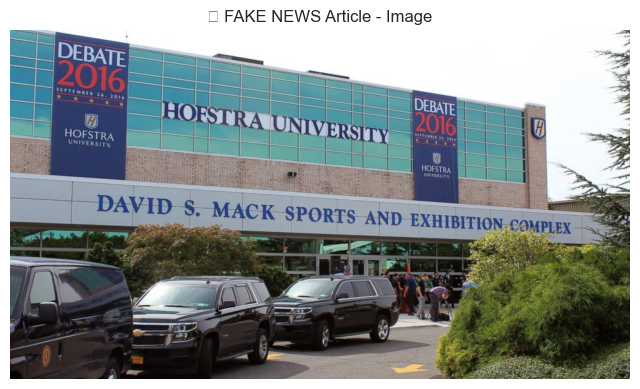


🟢 🟢 REAL NEWS EXEMPLE :
 - Titre: Black Caucus marches to DOJ to protest shootings
 - Texte: Reps. John Lewis (D-Ga.), Brenda Lawrence (D-Mich.), Maxine Waters (D-Calif.) and Cedric Richmond (D-La.), along with other members of the Congressional Black Caucus, hold a news conference after marc...
 - Image: image_final_ancien\5a725898c2c2dbd2c62bfc67adfe372e.jpg


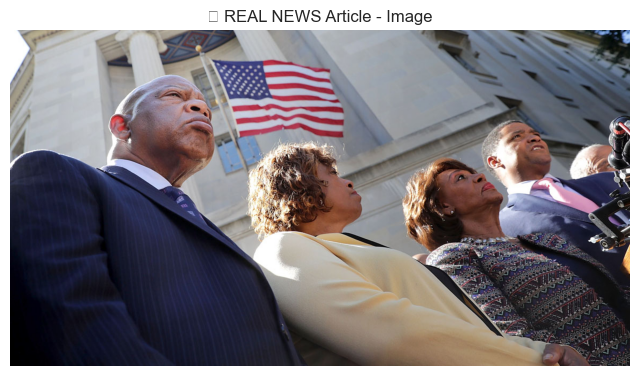


📊 VISUALISATIONS


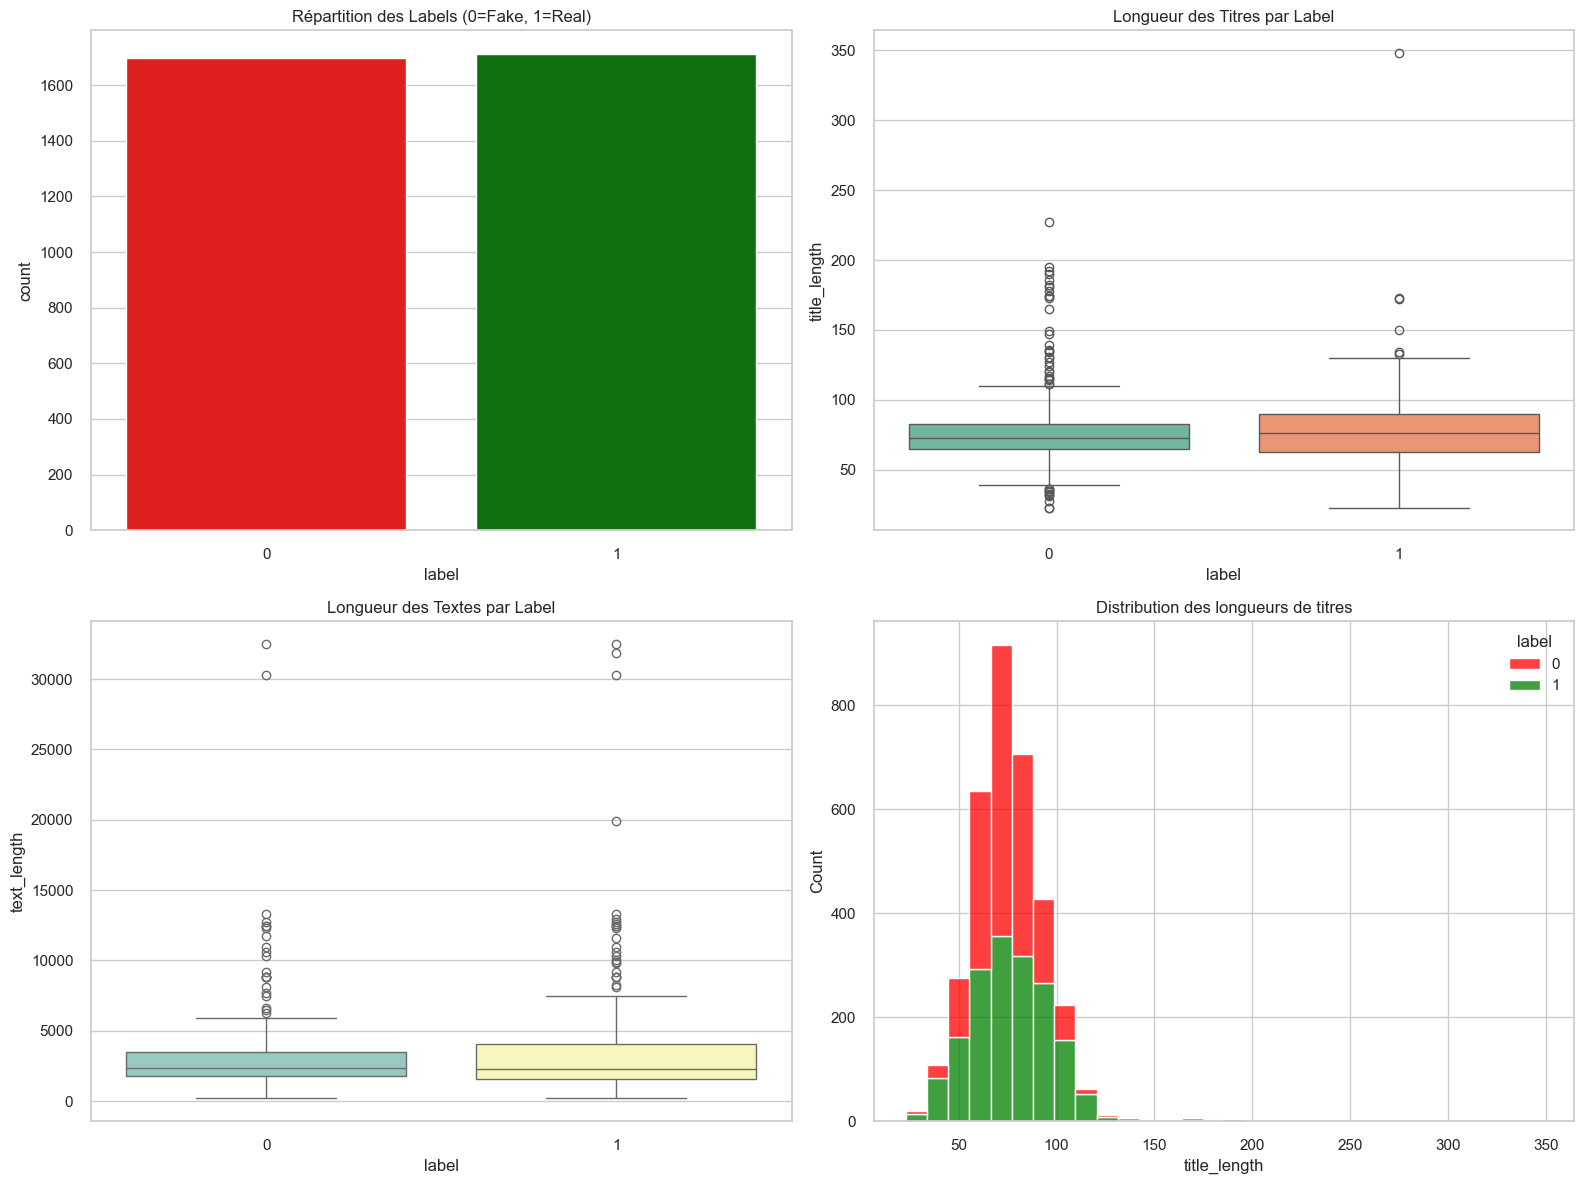


📊 MATRICE DE CORRÉLATION


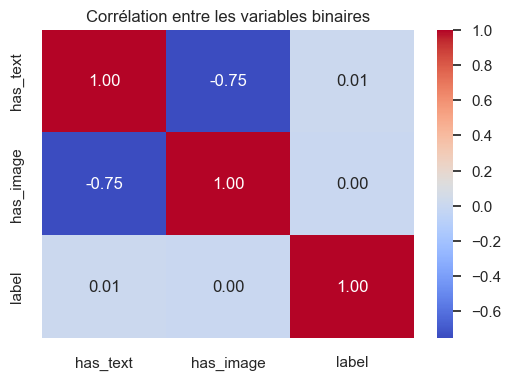

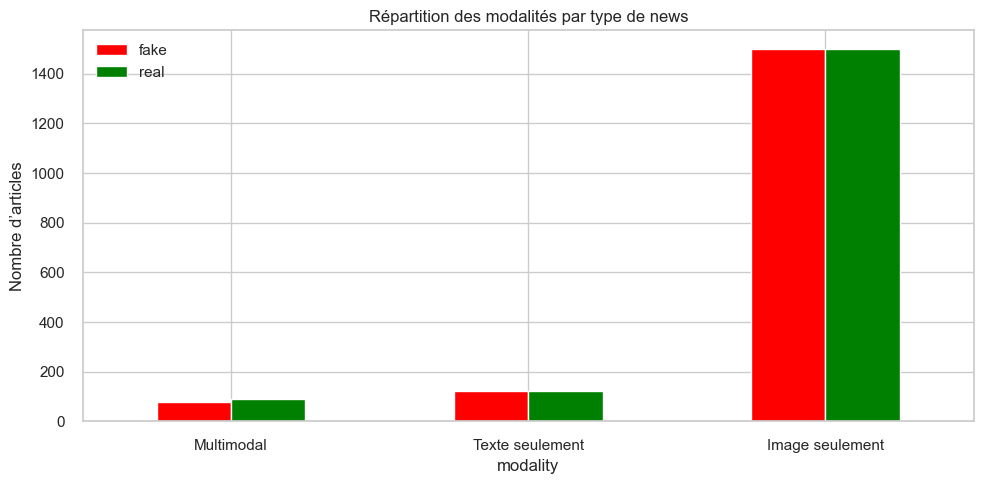


✅ Analyse exploratoire terminée.


In [ ]:
# Charger ton dataset équilibré
df_equilibre = pd.read_csv("df_multimodal_equilibre.csv")

# Lancer l’analyse exploratoire
df_analyzed = exploratory_analysis(df_equilibre)


Ces visualisations apportent plusieurs insights importants sur la répartition et les caractéristiques des données des articles fake news versus réels :

- La répartition des labels (fake vs real) montre un dataset équilibré, ce qui est idéal pour entraîner un modèle sans biais de classe, et garantit une évaluation fiable des performances.

- Le boxplot des longueurs des titres par label met en évidence une distribution similaire entre fake et real, avec cependant quelques titres fake plus longs, ce qui peut signaler une stratégie de désinformation basée sur des titres accrocheurs.

- Le boxplot des longueurs des textes révèle que les articles réels ont tendance à contenir plus de texte que les fake, ce qui suggère que la densité d'information peut être un indice pertinent pour la détection.

- L’histogramme des longueurs de titres permet de visualiser la concentration des titres entre 40 et 120 caractères, avec une légère dominance des fake dans les titres courts, ce qui peut orienter le traitement des séquences textuelles.
-La matrice de corrélation entre les variables binaires (has_text, has_image, label) met en évidence une forte corrélation négative entre la présence de texte et d’image, ce qui signifie que la majorité des articles sont soit purement textuels, soit purement visuels. Cela justifie le besoin de traiter chaque modalité différemment, voire de combiner intelligemment les deux pour les articles multimodaux.

- La répartition des modalités montre que la majorité des articles contiennent une image sans texte complet, mais accompagnés d’un titre. Cette visualisation nous a permis de mieux comprendre que la combinaison titre + image domine. Cela nous a aidés à ajuster notre pipeline pour tirer parti de cette combinaison, et nous oriente à l’avenir vers la conception de modèles multimodaux plus légers, exploitant efficacement les paires titre-image même en l’absence de texte long.

# En conclusion : 
Les visualisations confirment que le dataset est équilibré en labels, avec des variations utiles dans les longueurs de texte et de titres, ce qui guide le choix de seuils de prétraitement. La répartition des modalités montre que la majorité des articles combinent un titre avec une image, ce qui nous oriente vers des modèles multimodaux centrés sur cette structure.
Ces insights facilitent une préparation des données plus ciblée et cohérente avec la réalité du dataset.

# 4️⃣ Préparation des données pour la modélisation

Encodage des textes avec BERT et extraction des features d'images avec CNN.